In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE, VarianceThreshold, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns 

%matplotlib inline

In [2]:
#ignore warningsa
import warnings
warnings.filterwarnings('ignore')

In [3]:
def load_data():
    df = pd.read_csv('data/new_map.csv', header = 0)
    df.set_index(df.columns[0], inplace=True)
    df.rename_axis("ID", inplace=True)
    
    meta = pd.read_csv('data/samples_wo_UT.csv', header = 0)

    print(df.shape)
    print(meta.shape)
    
    mdf = pd.merge(df, meta, on='ID')
    
    print(mdf.shape)
    
    return mdf

In [4]:
def preprocess(df, *cols_to_exclude):
    df_copy = df.copy()
    cols_to_exclude = list(cols_to_exclude)
    cols_to_scale = [col for col in df.columns if col not in cols_to_exclude]
    scaler = MinMaxScaler()
    df_copy[cols_to_scale] = scaler.fit_transform(df_copy[cols_to_scale])       
    return df_copy

In [5]:
df = load_data()
df = df.drop(['ID'],axis = 1)
df = df.drop(['path', 'group', 'name','phenotype', 'genotype', 'cell', 'status',],axis=1)
x_train = preprocess(df,'target0')
y_train = df['target0']
x_train = x_train.drop('target0',axis = 1)
print(x_train.shape)
print(y_train.shape)
X = x_train
y = y_train

(32, 42334)
(29, 9)
(29, 42343)
(29, 42334)
(29,)


In [6]:
import random
import numpy as np
import torch

seed = 42  # or any fixed number you prefer

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [10]:
# feature selection method
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)
from xgboost import XGBClassifier
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.stats import spearmanr
from itertools import combinations

# Try with random features
# Example: Replace this with actual data loading
# X = <your_features>
# y = <your_labels>
#X = np.random.rand(32, 40000)  # Placeholder dataset with 32 samples and 40000 features
#y = np.random.randint(0, 2, 32)  # Placeholder binary labels

df = load_data()
df = df.drop(['ID'],axis = 1)
df = df.drop(['path', 'group', 'name','phenotype', 'genotype', 'cell', 'status',],axis=1)
x_train = preprocess(df,'target0')
y_train = df['target0']
x_train = df.drop('target0',axis = 1)
print(f'shape 1 {x_train.shape}')
print(y_train.shape)
X = x_train
y = y_train

# Check for class imbalance
print(f"Original class distribution: {Counter(y)}")

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(random_state=seed,max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=seed),
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=seed),
    "AdaBoost": AdaBoostClassifier(random_state=seed),
    "Decision Tree": DecisionTreeClassifier(random_state=seed),
    "SVM": SVC(probability=True, random_state=seed),
    "Naive Bayes": GaussianNB(),
}

# Scaling features
#scaler = StandardScaler()
#X = scaler.fit_transform(X)

#X = pd.DataFrame(X)
# Stratified K-Fold Cross Validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Feature Selection and Model Evaluation
results = {model_name: [] for model_name in models.keys()}
final_feature_names = []
common_features = None
feature_rankings = []
selected_features_list = []

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Apply SMOTE for oversampling the minority class
    smote = SMOTE(random_state=seed)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    print(f"Class distribution after SMOTE: {Counter(y_train)}")

    # Stage 1: Variance Threshold
    selector = VarianceThreshold(threshold=0.01)
    X_train = selector.fit_transform(X_train)
    X_test = selector.transform(X_test)
    feature_names = X.columns[selector.get_support()]
    print(f"Stage 1 - Variance Threshold: {len(feature_names)} features selected")
    print(X_train.shape)
    print(X_test.shape)
    
    # Stage 2: Univariate Feature Selection (ANOVA F-test)
    selector = SelectKBest(score_func=f_classif, k=5000)  # Select top 2000 features
    X_train = selector.fit_transform(X_train, y_train)
    X_test = selector.transform(X_test)
    feature_names = feature_names[selector.get_support()]
    print(f"Stage 2 - SelectKBest: {len(feature_names)} features selected")
    print(X_train.shape)
    print(X_test.shape)

    # Stage 3: Recursive Feature Elimination with Random Forest
    rfc = RandomForestClassifier(n_estimators=1000, random_state=42)
    rfc.fit(X_train, y_train)
    importances = rfc.feature_importances_
    indices = np.argsort(importances)[::-1][:1000]  # Select top 500 features
    X_train = X_train[:, indices]
    X_test = X_test[:, indices]
    feature_names = feature_names[indices]
    print(f"Stage 3 - Recursive Feature Elimination: {len(feature_names)} features selected")
    print(X_train.shape)
    print(X_test.shape)

    # Stage 4: Final Feature Reduction (Top 100 features using Lasso)
    lasso = Lasso(alpha=0.05, max_iter=1000, random_state=seed)
    lasso.fit(X_train, y_train)
    lasso_mask = np.argsort(np.abs(lasso.coef_))[::-1][:500]  # Indices of top 100 features
    X_train = X_train[:, lasso_mask]
    X_test = X_test[:, lasso_mask]
    final_feature_names = feature_names[lasso_mask]

    feature_rankings.append(final_feature_names)
    selected_features_list.append(set(final_feature_names))

    #print(f"Stage 4 - Final Feature Set: {len(final_feature_names)} features selected")
    print(X_train.shape)
    print(X_test.shape)
    #final_feature_names = feature_names
    #print(f'Final features list {final_feature_names.tolist()}')
  #  # Stage 4: Final Feature Reduction (Top 100 features)
  #  X_train = X_train[:, :100]
  #  X_test = X_test[:, :100]
  #  final_feature_names = feature_names[:100]
  #  print(f"Stage 4 - Final Feature Set: {len(final_feature_names)} features selected")
    # Track features across folds
    if common_features is None:
        common_features = set(final_feature_names)
    else:
        common_features.intersection_update(final_feature_names)
  
    # Bootstrapping for Model Evaluation
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        # Performance Metrics
        accuracy = accuracy_score(y_test, y_pred)
        sensitivity = recall_score(y_test, y_pred)
        specificity = recall_score(y_test, y_pred, pos_label=0)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba)

        results[model_name].append({
            "accuracy": accuracy,
            "sensitivity": sensitivity,
            "specificity": specificity,
            "f1_score": f1,
            "auc": roc_auc,
        })

# Compute Spearman Rank Stability
all_features = list(set().union(*feature_rankings))
rank_matrices = np.zeros((len(feature_rankings), len(all_features)))
for i, ranking in enumerate(feature_rankings):
    for j, feature in enumerate(all_features):
        if feature in ranking:
            rank_matrices[i, j] = ranking.tolist().index(feature) + 1
        else:
            rank_matrices[i, j] = len(ranking) + 1  # Assign lowest rank if not present

spearman_correlations = []
for i in range(len(rank_matrices) - 1):
    corr, _ = spearmanr(rank_matrices[i], rank_matrices[i + 1])
    spearman_correlations.append(corr)

mean_spearman_stability = np.mean(spearman_correlations)
print(f"Spearman Rank Stability: {mean_spearman_stability:.4f}")

# Summary of Results
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    for metric_name in ["accuracy", "sensitivity", "specificity", "f1_score", "auc"]:
        mean_metric = np.mean([m[metric_name] for m in metrics])
        print(f"  {metric_name}: {mean_metric:.4f}")

# Display final selected feature names
print("Final Selected Features (Top 100):", final_feature_names.tolist())
# Output common features across all folds
common_features = list(common_features)
print("\n--- Common Features Across All Folds ---")
print(common_features)


(32, 42334)
(29, 9)
(29, 42343)
shape 1 (29, 42334)
(29,)
Original class distribution: Counter({1: 16, 0: 13})
Class distribution after SMOTE: Counter({0: 12, 1: 12})
Stage 1 - Variance Threshold: 26248 features selected
(24, 26248)
(6, 26248)
Stage 2 - SelectKBest: 5000 features selected
(24, 5000)
(6, 5000)
Stage 3 - Recursive Feature Elimination: 1000 features selected
(24, 1000)
(6, 1000)
(24, 500)
(6, 500)
Class distribution after SMOTE: Counter({1: 13, 0: 13})
Stage 1 - Variance Threshold: 26494 features selected
(26, 26494)
(6, 26494)
Stage 2 - SelectKBest: 5000 features selected
(26, 5000)
(6, 5000)
Stage 3 - Recursive Feature Elimination: 1000 features selected
(26, 1000)
(6, 1000)
(26, 500)
(6, 500)
Class distribution after SMOTE: Counter({1: 13, 0: 13})
Stage 1 - Variance Threshold: 26350 features selected
(26, 26350)
(6, 26350)
Stage 2 - SelectKBest: 5000 features selected
(26, 5000)
(6, 5000)
Stage 3 - Recursive Feature Elimination: 1000 features selected
(26, 1000)
(6, 10

In [11]:
from scipy.stats import norm
import numpy as np

def compute_confidence_interval(data, confidence=0.95):
    """Compute mean, std, and confidence interval for given metric data."""
    a = np.array(data)
    mean = np.mean(a)
    std = np.std(a, ddof=1)
    z = norm.ppf(1 - (1 - confidence) / 2)
    ci = z * std / np.sqrt(len(a))

    # Cap CI between 0 and 1
    ci_lower = max(0, mean - ci)
    ci_upper = min(1, mean + ci)

    return mean, std, ci_lower, ci_upper

# Enhanced Summary of Results with CI and Std
for model_name, metrics in results.items():
    print(f"\nModel: {model_name}")
    for metric_name in ["accuracy", "sensitivity", "specificity", "f1_score", "auc"]:
        scores = [m[metric_name] for m in metrics]
        mean, std, ci_lower, ci_upper = compute_confidence_interval(scores)
        print(f"  {metric_name:<12}: Mean={mean:.4f}, Std={std:.4f}, 95% CI=({ci_lower:.4f}, {ci_upper:.4f})")



Model: Logistic Regression
  accuracy    : Mean=0.9667, Std=0.0745, 95% CI=(0.9013, 1.0000)
  sensitivity : Mean=1.0000, Std=0.0000, 95% CI=(1.0000, 1.0000)
  specificity : Mean=0.9333, Std=0.1491, 95% CI=(0.8027, 1.0000)
  f1_score    : Mean=0.9714, Std=0.0639, 95% CI=(0.9154, 1.0000)
  auc         : Mean=0.9444, Std=0.1242, 95% CI=(0.8356, 1.0000)

Model: Random Forest
  accuracy    : Mean=1.0000, Std=0.0000, 95% CI=(1.0000, 1.0000)
  sensitivity : Mean=1.0000, Std=0.0000, 95% CI=(1.0000, 1.0000)
  specificity : Mean=1.0000, Std=0.0000, 95% CI=(1.0000, 1.0000)
  f1_score    : Mean=1.0000, Std=0.0000, 95% CI=(1.0000, 1.0000)
  auc         : Mean=1.0000, Std=0.0000, 95% CI=(1.0000, 1.0000)

Model: XGBoost
  accuracy    : Mean=0.8667, Std=0.1394, 95% CI=(0.7444, 0.9889)
  sensitivity : Mean=0.9500, Std=0.1118, 95% CI=(0.8520, 1.0000)
  specificity : Mean=0.7667, Std=0.2236, 95% CI=(0.5707, 0.9627)
  f1_score    : Mean=0.8929, Std=0.1071, 95% CI=(0.7989, 0.9868)
  auc         : Mean=0.8

In [8]:
#model training and validation with common_features set

X_features = X[common_features]
#random_features = np.random.choice(X.columns, size=58, replace=False)
#X_features = X[random_features]

print(X_features.shape)
print(y.shape)

# Check for class imbalance
print(f"Original class distribution: {Counter(y)}")

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(random_state=seed,max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=seed),
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=seed),
    "AdaBoost": AdaBoostClassifier(random_state=seed),
    "Decision Tree": DecisionTreeClassifier(random_state=seed),
    "SVM": SVC(probability=True, random_state=seed),
    "Naive Bayes": GaussianNB(),
}

# Scaling features
#scaler = StandardScaler()
#X = scaler.fit_transform(X)

#X = pd.DataFrame(X)
# Stratified K-Fold Cross Validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Feature Selection and Model Evaluation
results = {model_name: [] for model_name in models.keys()}

for train_idx, test_idx in skf.split(X_features, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Apply SMOTE for oversampling the minority class
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    print(f"Class distribution after SMOTE: {Counter(y_train)}")

    # Bootstrapping for Model Evaluation
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        # Performance Metrics
        accuracy = accuracy_score(y_test, y_pred)
        sensitivity = recall_score(y_test, y_pred)
        specificity = recall_score(y_test, y_pred, pos_label=0)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba)

        results[model_name].append({
            "accuracy": accuracy,
            "sensitivity": sensitivity,
            "specificity": specificity,
            "f1_score": f1,
            "auc": roc_auc,
        })


# Summary of Results
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    for metric_name in ["accuracy", "sensitivity", "specificity", "f1_score", "auc"]:
        mean_metric = np.mean([m[metric_name] for m in metrics])
        print(f"  {metric_name}: {mean_metric:.4f}")


(29, 58)
(29,)
Original class distribution: Counter({1: 16, 0: 13})
Class distribution after SMOTE: Counter({0: 12, 1: 12})
Class distribution after SMOTE: Counter({1: 13, 0: 13})
Class distribution after SMOTE: Counter({1: 13, 0: 13})
Class distribution after SMOTE: Counter({1: 13, 0: 13})
Class distribution after SMOTE: Counter({1: 13, 0: 13})
Model: Logistic Regression
  accuracy: 0.8667
  sensitivity: 0.9000
  specificity: 0.8667
  f1_score: 0.8833
  auc: 0.9333
Model: Random Forest
  accuracy: 0.9000
  sensitivity: 1.0000
  specificity: 0.8000
  f1_score: 0.9214
  auc: 0.9556
Model: XGBoost
  accuracy: 0.9667
  sensitivity: 1.0000
  specificity: 0.9333
  f1_score: 0.9714
  auc: 0.9667
Model: AdaBoost
  accuracy: 0.8667
  sensitivity: 1.0000
  specificity: 0.7000
  f1_score: 0.8992
  auc: 0.8500
Model: Decision Tree
  accuracy: 0.8333
  sensitivity: 0.8000
  specificity: 0.8333
  f1_score: 0.8092
  auc: 0.8167
Model: SVM
  accuracy: 0.7333
  sensitivity: 0.8000
  specificity: 0.666

In [ ]:
from scipy.stats import norm
import numpy as np

def compute_confidence_interval(data, confidence=0.95):
    """Compute mean, std, and confidence interval for given metric data."""
    a = np.array(data)
    mean = np.mean(a)
    std = np.std(a, ddof=1)
    z = norm.ppf(1 - (1 - confidence) / 2)
    ci = z * std / np.sqrt(len(a))

    # Cap CI between 0 and 1
    ci_lower = max(0, mean - ci)
    ci_upper = min(1, mean + ci)

    return mean, std, ci_lower, ci_upper

# Enhanced Summary of Results with CI and Std
for model_name, metrics in results.items():
    print(f"\nModel: {model_name}")
    for metric_name in ["accuracy", "sensitivity", "specificity", "f1_score", "auc"]:
        scores = [m[metric_name] for m in metrics]
        mean, std, ci_lower, ci_upper = compute_confidence_interval(scores)
        print(f"  {metric_name:<12}: Mean={mean:.4f}, Std={std:.4f}, 95% CI=({ci_lower:.4f}, {ci_upper:.4f})")


(29, 58)
(29,)


  0%|          | 0/29 [00:00<?, ?it/s]

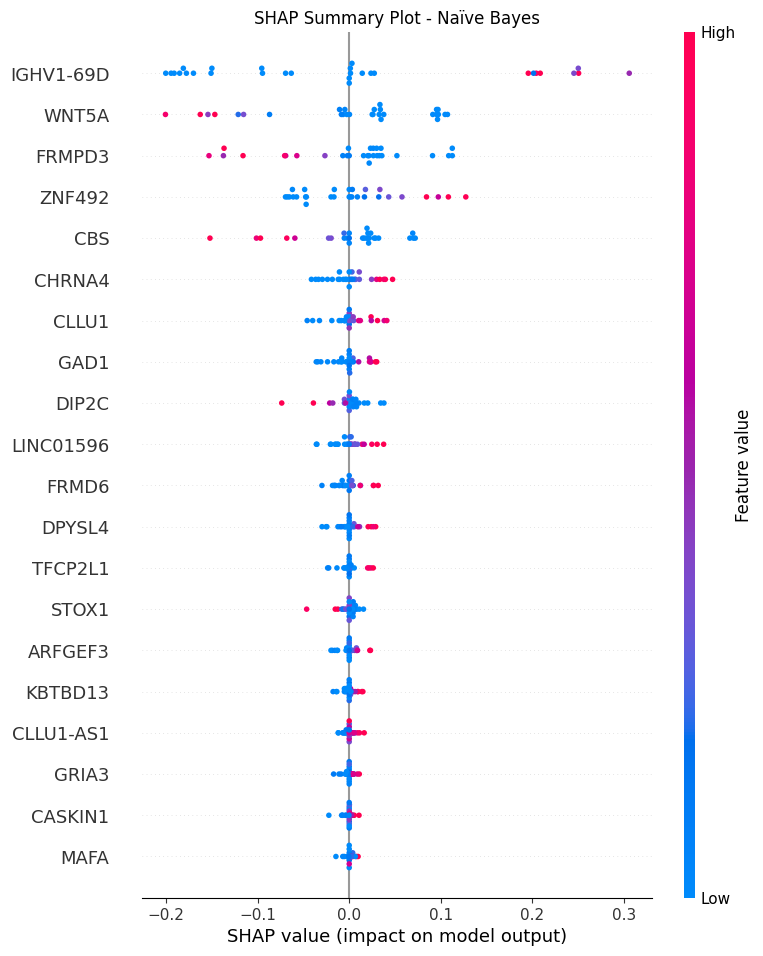

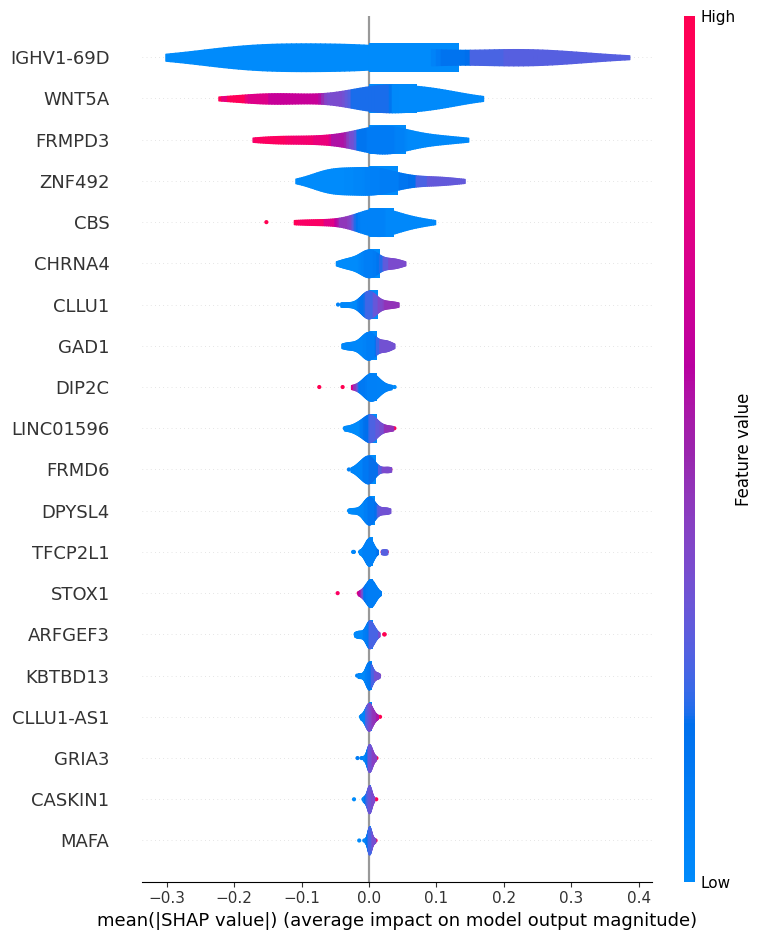

In [9]:
#SHAP with Naive Bayes
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_selected = X[common_features]
print(X_selected.shape)
print(y.shape)

# Train-test split
#X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Initialize Naïve Bayes model
model = GaussianNB()

# Train model
model.fit(X_selected, y)

# Compute SHAP values
explainer = shap.KernelExplainer(model.predict, X_selected)
shap_values = explainer.shap_values(X_selected)

# SHAP Summary Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_selected, show=False)
plt.title("SHAP Summary Plot - Naïve Bayes")
plt.show()

shap.plots.violin(shap_values,X_selected, show=False)
shap.summary_plot(shap_values,X_selected, show=False, plot_type="bar")


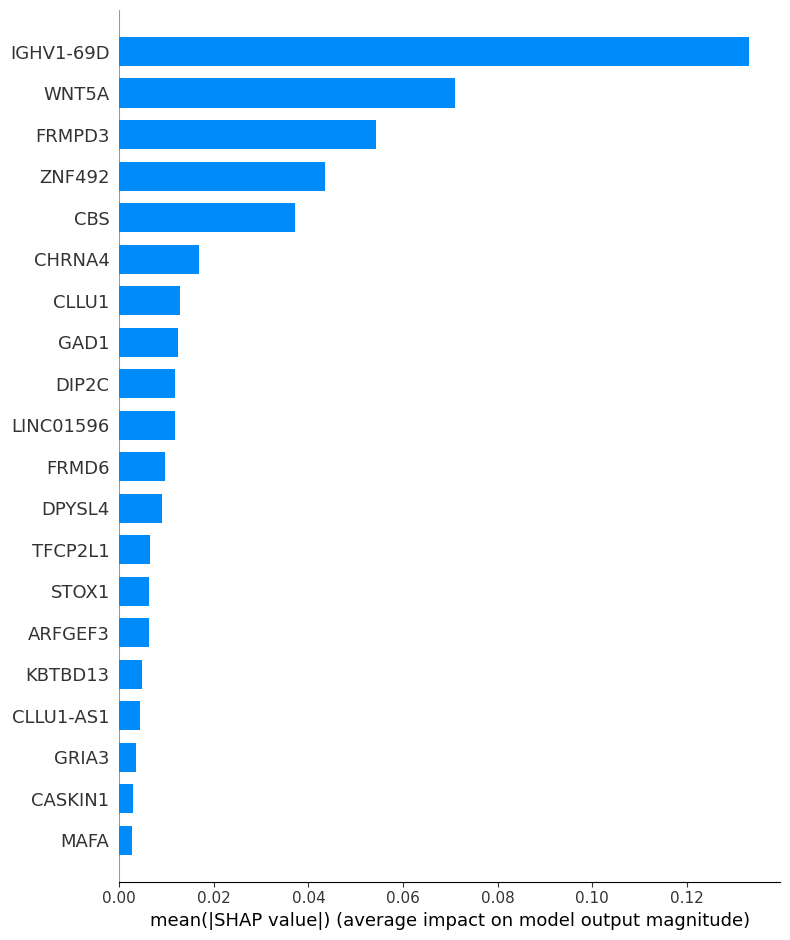

In [10]:
shap.summary_plot(shap_values,X_selected, show=False, plot_type="bar")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load data
df = pd.read_csv("data/plot.csv")  # Ensure correct formatting
print("Original Data Shape:", df.shape)

# Transpose data to have mRNAs as rows and Usher/Control as columns
df_t = df.T  # Transpose the dataframe
df_t.columns = df_t.iloc[0]  # Set mRNA names as column headers
df_t = df_t.iloc[1:]  # Remove the first row (old column headers)
df_t = df_t.apply(pd.to_numeric, errors='coerce')  # Convert values to numeric

#print("Transposed Data:\n", df_t)
#print("Transposed Data Shape:", df_t.shape)  # Should be (num_samples, 58)

# Apply Log Transformation for better visualization
df_t_log = np.log1p(df_t)  # log1p to prevent log(0) errors
#print("Log-Transformed Data:\n", df_t_log)

# Create Heatmap
plt.figure(figsize=(14, 8))  # Adjusted figure size for better visualization
ax = sns.heatmap(
    df_t_log, 
    cmap="OrRd", 
    annot=False, 
    linewidths=0.5, 
    yticklabels=True  # Ensure y-axis labels are shown
)

# Formatting
#plt.title("Heatmap of Log-Scaled mRNA Expression in Usher vs. Control", fontsize=16)
plt.xlabel("mRNAs", fontsize=12)
plt.ylabel("Expression Level", fontsize=12)
plt.xticks(rotation=90)  # Rotate sample labels for better readability

# Ensure all 58 mRNA labels appear on the y-axis
ax.set_yticks(np.arange(df_t_log.shape[0]) + 0.5)  # Center y-ticks
ax.set_yticklabels(df_t_log.index, fontsize=10, rotation=0)  # Show all mRNA names

plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.savefig("heatmap_light_palette.jpg", dpi=600,format="jpg", bbox_inches="tight")
plt.show()


In [ ]:
import requests
import pandas as pd

# Function to perform g:Profiler analysis in batches
def gprofiler_analysis(gene_list, batch_size=1, significance_threshold=0.05):
    url = "https://biit.cs.ut.ee/gprofiler/api/gost/profile/"
    all_results = []
    for i in range(0, len(gene_list), batch_size):
        # Split gene list into batches
        batch = gene_list[i:i + batch_size]
        payload = {
            "organism": "hsapiens",
            "query": batch,
            "sources": ["GO:BP", "GO:MF", "GO:CC", "KEGG", "REAC", "WP", "MSigDB", "PANTHER"],
            "user_threshold": significance_threshold,
        }
        response = requests.post(url, json=payload, verify=False)
        if response.status_code == 200:
            results = response.json()
            if "result" in results and results["result"]:
                for result in results["result"]:
                    flattened_genes = [gene for sublist in result["intersections"] for gene in sublist]
                    all_results.append({
                        "Pathway": result["name"],
                        "Source": result["source"],
                        "P-Value": result["p_value"],
                        "Genes": ", ".join(flattened_genes)
                    })
            else:
                print(f"No pathways found for batch: {batch}")
        else:
            print(f"Request failed for batch: {batch} with status code {response.status_code}")
    
    # Return results as a DataFrame
    if all_results:
        pathway_df = pd.DataFrame(all_results)
        significant_pathways = pathway_df[pathway_df["P-Value"] < significance_threshold]
        print("Significant Pathways:")
        print(significant_pathways)
        significant_pathways.to_csv("kegg_pathway_analysis_results.csv", index=False)
        print("Results saved to 'kegg_pathway_analysis_results.csv'")
    else:
        print("No significant pathways found for the entire gene list.")

# Function to plot a bubble chart
def plot_bubble_chart(pathway_df):
    if pathway_df.empty:
        print("No significant pathways to plot.")
        return
    
    # Set up the plot
    plt.figure(figsize=(10, 6))
    sns.set(style="whitegrid")

    # Create a bubble chart where:
    # - X-axis represents the pathways
    # - Y-axis represents the P-Values
    # - Bubble size represents the number of genes
    # - Bubble color represents the Source of the pathway
    pathway_df['Gene Count'] = pathway_df['Genes'].apply(lambda x: len(x.split(', ')))  # Count number of genes
    
    plt.scatter(
        pathway_df['Pathway'], pathway_df['P-Value'],
        s=pathway_df['Gene Count'] * 20,  # Adjust bubble size for visibility
        c=pd.Categorical(pathway_df['Source']).codes, cmap='viridis', alpha=0.6
    )

    # Add labels and title
    plt.xlabel('Pathway')
    plt.ylabel('P-Value')
    plt.title('Bubble Chart of Significant Pathways')
    plt.xticks(rotation=90)  # Rotate X-axis labels for readability
    plt.colorbar(label='Pathway Source')
    
    plt.tight_layout()
    plt.show()


# Example usage
gene_list = [
    "EMA6D", "CTSH", "ABCA9", "LMNA", "PSAT1", "FRY", "G2E3", "BATF2", "SATB2", "HDAC9", 
    "LINC01596", "FRMD6", "ZCCHC14", "SHF", "DENND1B", "CPNE1", "ARFGEF3", "CBS", "TNFRSF19"
]

gene_list = final_feature_names.tolist()
formatted_genes = str(gene_list).replace("'", '"')

gene_list = ["ABLIM1",  "CHRNA4",
 "STOX1",
 "PPP1R27",
 "GAD1",
 "HDAC9",
 "CBARP",
 "SHF",
 "ZNF492",
 "FRMD6",
 "TEX15",
 "CD200R1",
 "LMO7",
 "DIP2C",
 "TFCP2L1",
 "GPR135",
 "CRYBG3",
 "DNAJC15",
 "AS3MT",
 "TRNP1",
 "TIPARP",
 "CLLU1",
 "TNFRSF19",
 "GNB5",
 "AGTRAP",
 "ARFGEF3",
 "ZSCAN18",
 "SLC3A2",
 "C2orf88",
 "GAS8",
 "CASKIN1",
 "CCND1",
 "ROBO1",
 "ZNF295-AS1",
 "STAP1",
 "MAFA",
 "GRIA3",
 "IGHV1-69D",
 "FRY",
 "LINC01596",
 "IRF6",
 "CLLU1-AS1",
 "POM121B",
 "ZCCHC14",
 "WNT5A",
 "CTSH",
 "KLF3",
 "ZNF229",
 "FRMD6-AS2",
 "ISLR2",
 "DCHS1",
 "KBTBD13",
 "CPA4",
 "FRMPD3",
 "CBS",
 "ZFP28",
 "DPYSL4",
 "BAIAP2"]

significant_pathways = gprofiler_analysis(gene_list)

# Plot the bubble chart
plot_bubble_chart(significant_pathways)
